In [1]:
import numpy as np
import pickle
from os import listdir
from os.path import isfile, join
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score



In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


## **Importing the dataset from the local directory**

In [3]:
# Function to unpickle the dataset
def unpickle_all_data(directory):
    
    # Initialize the variables
    train = dict()
    test = dict()
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    
    # Iterate through all files that we want, train and test
    # Train is separated into batches
    for filename in listdir(directory):
        if isfile(join(directory, filename)):
            
            # The train data
            if 'data_batch' in filename:
                print('Handing file: %s' % filename)
                
                # Opent the file
                with open(directory + '/' + filename, 'rb') as fo:
                    data = pickle.load(fo, encoding='bytes')

                if 'data' not in train:
                    train['data'] = data[b'data']
                    train['labels'] = np.array(data[b'labels'])
                else:
                    train['data'] = np.concatenate((train['data'], data[b'data']))
                    train['labels'] = np.concatenate((train['labels'], data[b'labels']))
            # The test data
            elif 'test_batch' in filename:
                print('Handing file: %s' % filename)
                
                # Open the file
                with open(directory + '/' + filename, 'rb') as fo:
                    data = pickle.load(fo, encoding='bytes')
                
                test['data'] = data[b'data']
                test['labels'] = data[b'labels']
    
    # Manipulate the data to the propper format
    for image in train['data']:
        train_x.append(np.transpose(np.reshape(image,(3, 32,32)), (1,2,0)))
    train_y = [label for label in train['labels']]
    
    for image in test['data']:
        test_x.append(np.transpose(np.reshape(image,(3, 32,32)), (1,2,0)))
    test_y = [label for label in test['labels']]
    
    # Transform the data to np array format
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    test_x = np.array(test_x)
    test_y = np.array(test_y)
    
    return (train_x, train_y), (test_x, test_y)

# Run the function with and include the folder where the data are
(X_train, y_train), (X_test, y_test) = unpickle_all_data(r"C:\Users\rohan\Desktop\PRML_Project\cifar-10-python\cifar-10-batches-py")



Handing file: data_batch_1
Handing file: data_batch_2
Handing file: data_batch_3
Handing file: data_batch_4
Handing file: data_batch_5
Handing file: test_batch


## **Data Preprocessing**

### LOADING THE DATASET

Reference of the dataset : https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf  
Dataset and methodology followed is decribed in greater detail in the above cited link.


In [7]:
# we will load the cifar10 dataset from keras
# reference : https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf
# dataset and methodology followed is decribed in greater detail in the above cited link.
# from keras.datasets import cifar10

# (X_train, y_train),(X_test, y_test) = cifar10.load_data()


ABOUT THE DATASET -


*   The dataset has 50000 training samples and 10000 test samples
*   cifar10 implies 10 class labels (or target labels)
*   Each sample has the shape (32,32,3)
*   Pixels in 32X32 images are indexed in values of three channels of Red, Blue and Green



In [4]:
print(f'Shape of the training set (features): {X_train.shape}')
print(f'Shape of the training set (target): {y_train.shape}')
print(f'Shape of the test set (features): {X_test.shape}')
print(f'Shape of the test set (target): {y_test.shape}')


Shape of the training set (features): (50000, 32, 32, 3)
Shape of the training set (target): (50000,)
Shape of the test set (features): (10000, 32, 32, 3)
Shape of the test set (target): (10000,)


### Visualizing the image set

Text(0.5, 1.0, 'A single image')

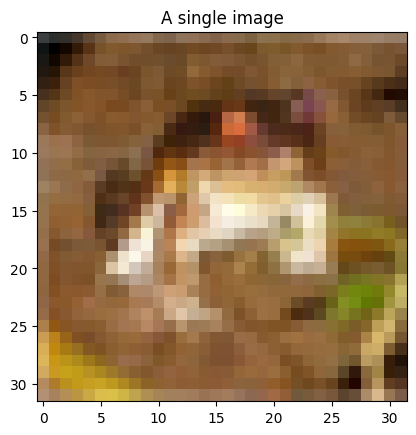

In [45]:
#plotting the first sample of the trainging set
plt.imshow(X_train[0])
plt.title('A single image')

In [4]:
print(y_train)

[6 9 9 ... 9 1 1]


The target set contains integer class labels representing one of the ten classes in the CIFAR-10 dataset.



In [47]:
# These are the classnames in the dataset in the order
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


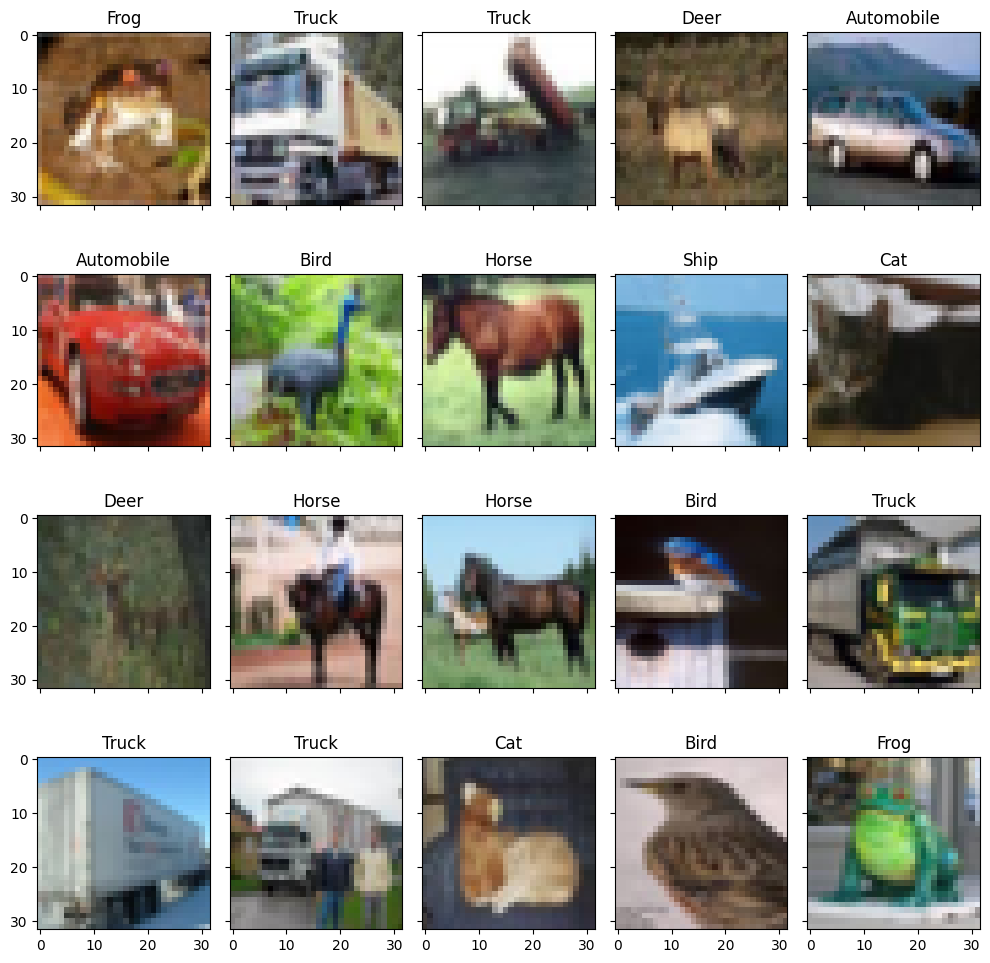

In [48]:
#making a subplot of first few images

fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
  ax.imshow(X_train[i])
  ax.set_title(class_names[y_train[i]])
  # ax.set_title(class_names[y_train[i][0]])

plt.tight_layout()
plt.show()

Data Normalisation

In [5]:
# Flattening the features array
# Flattening is typically done as traditional ml models require input in 2-d format
# more on the 2-d format - each row represents a single sample (image) and each column represents a feature (pixel).
print(f"here is X_train's shape before Flattening \n{X_train.shape}")
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"here is X_train's shape after Flattening \n{X_train_flat.shape}")
# As the pixel values in rgb channel of feature set range from 0-255 we are scaling it down to 0.0-1.0

min_value = np.min(X_train_flat)
max_value = np.max(X_train_flat)
# Perform min-max normalization
X_train_normalized = (X_train_flat - min_value) / (max_value - min_value)
X_test_normalized = (X_test_flat - min_value) / (max_value - min_value)

here is X_train's shape before Flattening 
(50000, 32, 32, 3)
here is X_train's shape after Flattening 
(50000, 3072)


In [24]:
# print(f'here is the y_train before Flattening : \n',y_train)
# print(f'here is the shape of y_train before Flattening : ',y_train.shape)


# # Flatten target labels
# y_train = np.ravel(y_train)
# print(f"\nhere is y_train after Flattening \n{y_train} \n and it's shape after Flattening\n{y_train.shape}")

# print('\nsimilar process is for y_test')
# y_test = np.ravel(y_test)


array([3, 8, 8, ..., 5, 1, 7])

## **Testing some classical machine learning models**

### KNN

In [50]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
# Train the classifier
knn_classifier.fit(X_train_normalized, y_train)

# Predict labels for test set
y_pred = knn_classifier.predict(X_test_normalized)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy of KNN:", accuracy)
print("Precision of KNN:", precision)
print("Recall of KNN:", recall)
print("F1 Score of KNN:", f1)


Accuracy of KNN: 0.3398
Precision of KNN: 0.4304261825528496
Recall of KNN: 0.3398
F1 Score of KNN: 0.3260170986061005


### Decision tree

In [52]:
# Train Decision Tree classifier
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train_normalized, y_train)

# Predict labels for test set
y_pred_decision_tree = decision_tree_model.predict(X_test_normalized)

accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree, average='weighted')
recall_decision_tree = recall_score(y_test, y_pred_decision_tree, average='weighted')
f1_decision_tree = f1_score(y_test, y_pred_decision_tree, average='weighted')

print("Accuracy of Decision Tree Classifier:", accuracy_decision_tree)
print("Precision of Decision Tree Classifier:", precision_decision_tree)
print("Recall of Decision Tree Classifier:", recall_decision_tree)
print("F1 Score of Decision Tree Classifier:", f1_decision_tree)


### Random forest classifier

In [63]:
# Train Random Forest classifier
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train_normalized, y_train)

y_pred_random_forest = random_forest_model.predict(X_test_normalized)


accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
precision_random_forest = precision_score(y_test, y_pred_random_forest, average='weighted')
recall_random_forest = recall_score(y_test, y_pred_random_forest, average='weighted')
f1_random_forest = f1_score(y_test, y_pred_random_forest, average='weighted')

print("Accuracy of Random Forest Classifier:", accuracy_random_forest)
print("Precision of Random Forest Classifier:", precision_random_forest)
print("Recall of Random Forest Classifier:", recall_random_forest)
print("F1 Score of Random Forest Classifier:", f1_random_forest)

Accuracy of Random Forest Classifier: 0.4725
Precision of Random Forest Classifier: 0.46822660166058794
Recall of Random Forest Classifier: 0.4725
F1 Score of Random Forest Classifier: 0.4686901305308043


### Naive bayes classifier

In [65]:
# Train Naive Bayes classifier
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train_normalized, y_train)

y_pred_naive_bayes = naive_bayes_model.predict(X_test_normalized)

accuracy_naive_bayes = accuracy_score(y_test, y_pred_naive_bayes)
precision_naive_bayes = precision_score(y_test, y_pred_naive_bayes, average='weighted')
recall_naive_bayes = recall_score(y_test, y_pred_naive_bayes, average='weighted')
f1_naive_bayes = f1_score(y_test, y_pred_naive_bayes, average='weighted')

print("Accuracy of Naive Bayes Classifier:", accuracy_naive_bayes)
print("Precision of Naive Bayes Classifier:", precision_naive_bayes)
print("Recall of Naive Bayes Classifier:", recall_naive_bayes)
print("F1 Score of Naive Bayes Classifier:", f1_naive_bayes)

Accuracy of Naive Bayes Classifier: 0.2976
Precision of Naive Bayes Classifier: 0.31121406674181173
Recall of Naive Bayes Classifier: 0.2976
F1 Score of Naive Bayes Classifier: 0.27546278386551976


### SVM

In [6]:
# Train the SVM model
svm_classifier = SVC(kernel='rbf', gamma='scale', C=1.0)  # You can adjust kernel, gamma, and C parameters
svm_classifier.fit(X_train_normalized, y_train)

# Make predictions
y_pred = svm_classifier.predict(X_test_normalized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Now we are performing the LDA on dataset so that classes gets max spreted which we want and we get betteer results

In [6]:
# Apply LDA
lda = LinearDiscriminantAnalysis()  # Adjust the number of components as per requirement
X_train_lda = lda.fit_transform(X_train_normalized, y_train)
X_test_lda = lda.transform(X_test_normalized)
print(X_train_lda.shape)
# KNN Classifier
knn = KNeighborsClassifier()
knn.fit(X_train_lda, y_train)
y_pred_knn = knn.predict(X_test_lda)

# Decision Tree Classifier
dt = DecisionTreeClassifier()
dt.fit(X_train_lda, y_train)
y_pred_dt = dt.predict(X_test_lda)

# Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X_train_lda, y_train)
y_pred_rf = rf.predict(X_test_lda)

# Naive Bayes Classifier
nb = GaussianNB()
nb.fit(X_train_lda, y_train)
y_pred_nb = nb.predict(X_test_lda)

# SVM
svm = SVC(kernel='rbf', gamma='scale', C=1.0)
svm.fit(X_train_lda, y_train)
y_pred_svm = svm.predict(X_test_lda)

# Evaluate models
print("K-Nearest Neighbors:")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision:", precision_score(y_test, y_pred_knn, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_knn, average='weighted'))

print("\nDecision Tree:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_dt, average='weighted'))

print("\nRandom Forest:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_rf, average='weighted'))

print("\nNaive Bayes:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_nb, average='weighted'))

print("\nSVM:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_svm, average='weighted'))

(50000, 9)

SVM:
Accuracy: 0.3737
Precision: 0.3730106493100517
Recall: 0.3737


## **Performing PCA**

In [67]:
from sklearn.decomposition import PCA
# Apply PCA
pca = PCA(n_components=0.95)  # retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)

n_components_chosen = pca.n_components_
print("Number of components chosen:", n_components_chosen)

Number of components chosen: 217


### KNN

In [68]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
# Train the classifier
knn_classifier.fit(X_train_pca, y_train)

# Predict labels for test set
y_pred = knn_classifier.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy of KNN:", accuracy)
print("Precision of KNN:", precision)
print("Recall of KNN:", recall)
print("F1 Score of KNN:", f1)

Accuracy of KNN: 0.3625
Precision of KNN: 0.4466677313172691
Recall of KNN: 0.3625
F1 Score of KNN: 0.354497969454903


### Decision Tree

In [69]:
# Train Decision Tree classifier
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train_pca, y_train)

# Predict labels for test set
y_pred_decision_tree = decision_tree_model.predict(X_test_pca)

accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree, average='weighted')
recall_decision_tree = recall_score(y_test, y_pred_decision_tree, average='weighted')
f1_decision_tree = f1_score(y_test, y_pred_decision_tree, average='weighted')

print("Accuracy of Decision Tree Classifier:", accuracy_decision_tree)
print("Precision of Decision Tree Classifier:", precision_decision_tree)
print("Recall of Decision Tree Classifier:", recall_decision_tree)
print("F1 Score of Decision Tree Classifier:", f1_decision_tree)

Accuracy of Decision Tree Classifier: 0.2589
Precision of Decision Tree Classifier: 0.2589049176115985
Recall of Decision Tree Classifier: 0.2589
F1 Score of Decision Tree Classifier: 0.2587282417515696


### Random Forset 

In [70]:
# Train Random Forest classifier
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train_pca, y_train)

y_pred_random_forest = random_forest_model.predict(X_test_pca)


accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
precision_random_forest = precision_score(y_test, y_pred_random_forest, average='weighted')
recall_random_forest = recall_score(y_test, y_pred_random_forest, average='weighted')
f1_random_forest = f1_score(y_test, y_pred_random_forest, average='weighted')

print("Accuracy of Random Forest Classifier:", accuracy_random_forest)
print("Precision of Random Forest Classifier:", precision_random_forest)
print("Recall of Random Forest Classifier:", recall_random_forest)
print("F1 Score of Random Forest Classifier:", f1_random_forest)

Accuracy of Random Forest Classifier: 0.4365
Precision of Random Forest Classifier: 0.43245711819164034
Recall of Random Forest Classifier: 0.4365
F1 Score of Random Forest Classifier: 0.4326432236045719


### Naive Bayes

In [71]:
# Train Naive Bayes classifier
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train_pca, y_train)

y_pred_naive_bayes = naive_bayes_model.predict(X_test_pca)

accuracy_naive_bayes = accuracy_score(y_test, y_pred_naive_bayes)
precision_naive_bayes = precision_score(y_test, y_pred_naive_bayes, average='weighted')
recall_naive_bayes = recall_score(y_test, y_pred_naive_bayes, average='weighted')
f1_naive_bayes = f1_score(y_test, y_pred_naive_bayes, average='weighted')

print("Accuracy of Naive Bayes Classifier:", accuracy_naive_bayes)
print("Precision of Naive Bayes Classifier:", precision_naive_bayes)
print("Recall of Naive Bayes Classifier:", recall_naive_bayes)
print("F1 Score of Naive Bayes Classifier:", f1_naive_bayes)

Accuracy of Naive Bayes Classifier: 0.3122
Precision of Naive Bayes Classifier: 0.33380316708946484
Recall of Naive Bayes Classifier: 0.3122
F1 Score of Naive Bayes Classifier: 0.29941025377966646


## **Feature Extraction and Tuning parameters**

### ResNet Features

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

In [76]:
# Calculate mean and standard deviation
mean_data = np.mean(X_train, axis=(0, 1, 2)) / 255  
std_data = np.std(X_train, axis=(0, 1, 2)) / 255  

preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_data, std=std_data),
    ])
# Load pre-trained ResNet-50 model
resnet = models.resnet50(pretrained=True)
# resnet = models.resnet50(weights='imagenet')

# Remove the last fully connected layer
resnet = nn.Sequential(*list(resnet.children())[:-1])
# Set the model to evaluation mode
resnet.eval()
all_features = []
X_train_features = []
for image_data in X_train:
    image = Image.fromarray(image_data)  #Converting to type PIL.Image
    image = preprocess(image)
    image = image.unsqueeze(0)
    # Extract features
    with torch.no_grad():
        features = resnet(image)
    # Remove the batch dimension
    features = features.squeeze(0)
    all_features.append(features.numpy())
    X_train_features.append(features.numpy())

X_test_features = []
for image_data in X_test:
    image = Image.fromarray(image_data)  #Converting to type PIL.Image
    image = preprocess(image)
    image = image.unsqueeze(0)
    # Extract features
    with torch.no_grad():
        features = resnet(image)
    # Remove the batch dimension
    features = features.squeeze(0)
    all_features.append(features.numpy())
    X_test_features.append(features.numpy())

# all_features_tensor = torch.tensor(all_features)
all_features_array = np.array(all_features)
all_features_tensor = torch.tensor(all_features_array)
# Save the extracted features to a file
torch.save(all_features_tensor, 'extracted_features.pt')

In [77]:
print(all_features_tensor.shape)

torch.Size([60000, 2048, 1, 1])


Loading the saved features and selecting the training data and testing data

In [7]:
# Load the saved features from the file
loaded_features = torch.load('extracted_features.pt')
X_train_features = loaded_features[:50000]
X_test_features = loaded_features[50000:]

In [8]:
print(X_train.shape)
# Changing the shape
X_train = np.array(X_train_features).reshape(X_train.shape[0], -1)
X_test = np.array(X_test_features).reshape(X_test.shape[0], -1)


(50000, 32, 32, 3)


### KNN

In [31]:
knn_classifier = KNeighborsClassifier(n_neighbors=7)

# Train the classifier
knn_classifier.fit(X_train, y_train)

# Predict labels for test set
y_pred = knn_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy of KNN:", accuracy)
print("Precision of KNN:", precision)
print("Recall of KNN:", recall)
print("F1 Score of KNN:", f1)

Accuracy of KNN: 0.8408
Precision of KNN: 0.8449391444512696
Recall of KNN: 0.8408
F1 Score of KNN: 0.840755764730697


Finding optimum value of 'k'

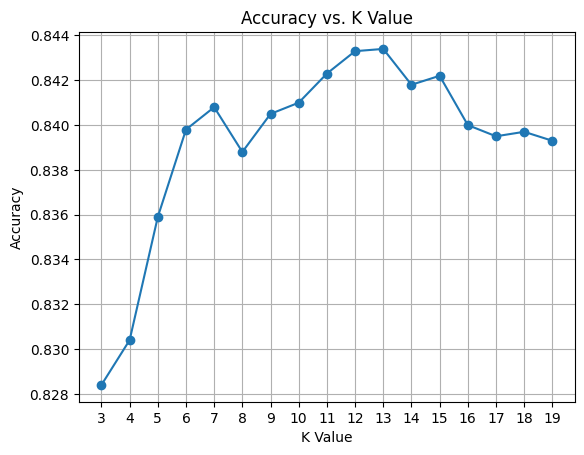

Best value of k: 13


In [20]:
import matplotlib.pyplot as plt

# Define a range of k values to try
k_values = range(3, 20)  # You can adjust the range as needed

# Initialize lists to store accuracies for each k
accuracies = []

# Iterate over each value of k
for k in k_values:
    # Create and train the KNN classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, y_train)
    
    # Predict labels for the validation set
    y_pred = knn_classifier.predict(X_test)
    
    # Calculate accuracy and store it
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plot k versus accuracy
plt.plot(k_values, accuracies, marker='o')
plt.title('Accuracy vs. K Value')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Find the k value with the highest accuracy
best_k = k_values[accuracies.index(max(accuracies))]
print("Best value of k:", best_k)


In [21]:
#using the best value of k
knn_classifier = KNeighborsClassifier(n_neighbors=13)

# Train the classifier
knn_classifier.fit(X_train, y_train)

# Predict labels for test set
y_pred = knn_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy of KNN:", accuracy)
print("Precision of KNN:", precision)
print("Recall of KNN:", recall)
print("F1 Score of KNN:", f1)

Accuracy of KNN: 0.8434
Precision of KNN: 0.848380873014827
Recall of KNN: 0.8434
F1 Score of KNN: 0.8432689748734811


Finding inaccuracies

Misclassifications count per class:
Class 6: 99 misclassifications
Class 5: 238 misclassifications
Class 7: 169 misclassifications
Class 4: 178 misclassifications
Class 1: 76 misclassifications
Class 3: 211 misclassifications
Class 2: 291 misclassifications
Class 0: 145 misclassifications
Class 9: 96 misclassifications
Class 8: 63 misclassifications


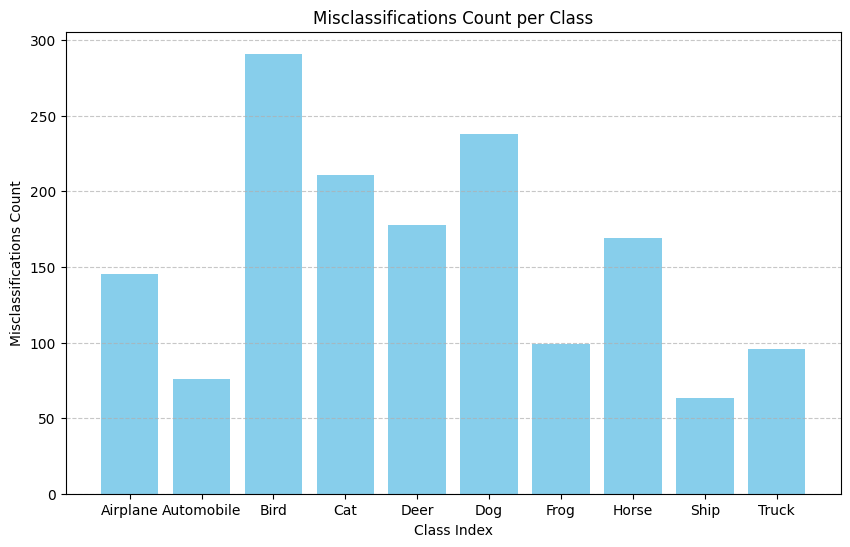

In [29]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = knn_classifier.predict(X_test)

# Create a dictionary to store misclassifications count for each class
misclassifications_count = defaultdict(int)

# Iterate through the test set and count misclassifications
for true_label, predicted_label in zip(y_test, y_pred):
    if true_label != predicted_label:
        misclassifications_count[true_label] += 1

# Print misclassifications count for each class
print("Misclassifications count per class:")
for class_index, count in misclassifications_count.items():
    print(f"Class {class_index}: {count} misclassifications")

# Visualize misclassifications 
# Convert misclassifications count dictionary to lists for plotting
classes = list(misclassifications_count.keys())
misclassifications = [misclassifications_count[i] for i in range(len(class_names))]

# Plot misclassifications count for each class using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, misclassifications, color='skyblue')
plt.title('Misclassifications Count per Class')
plt.xlabel('Class Index')
plt.ylabel('Misclassifications Count')
plt.xticks(classes)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


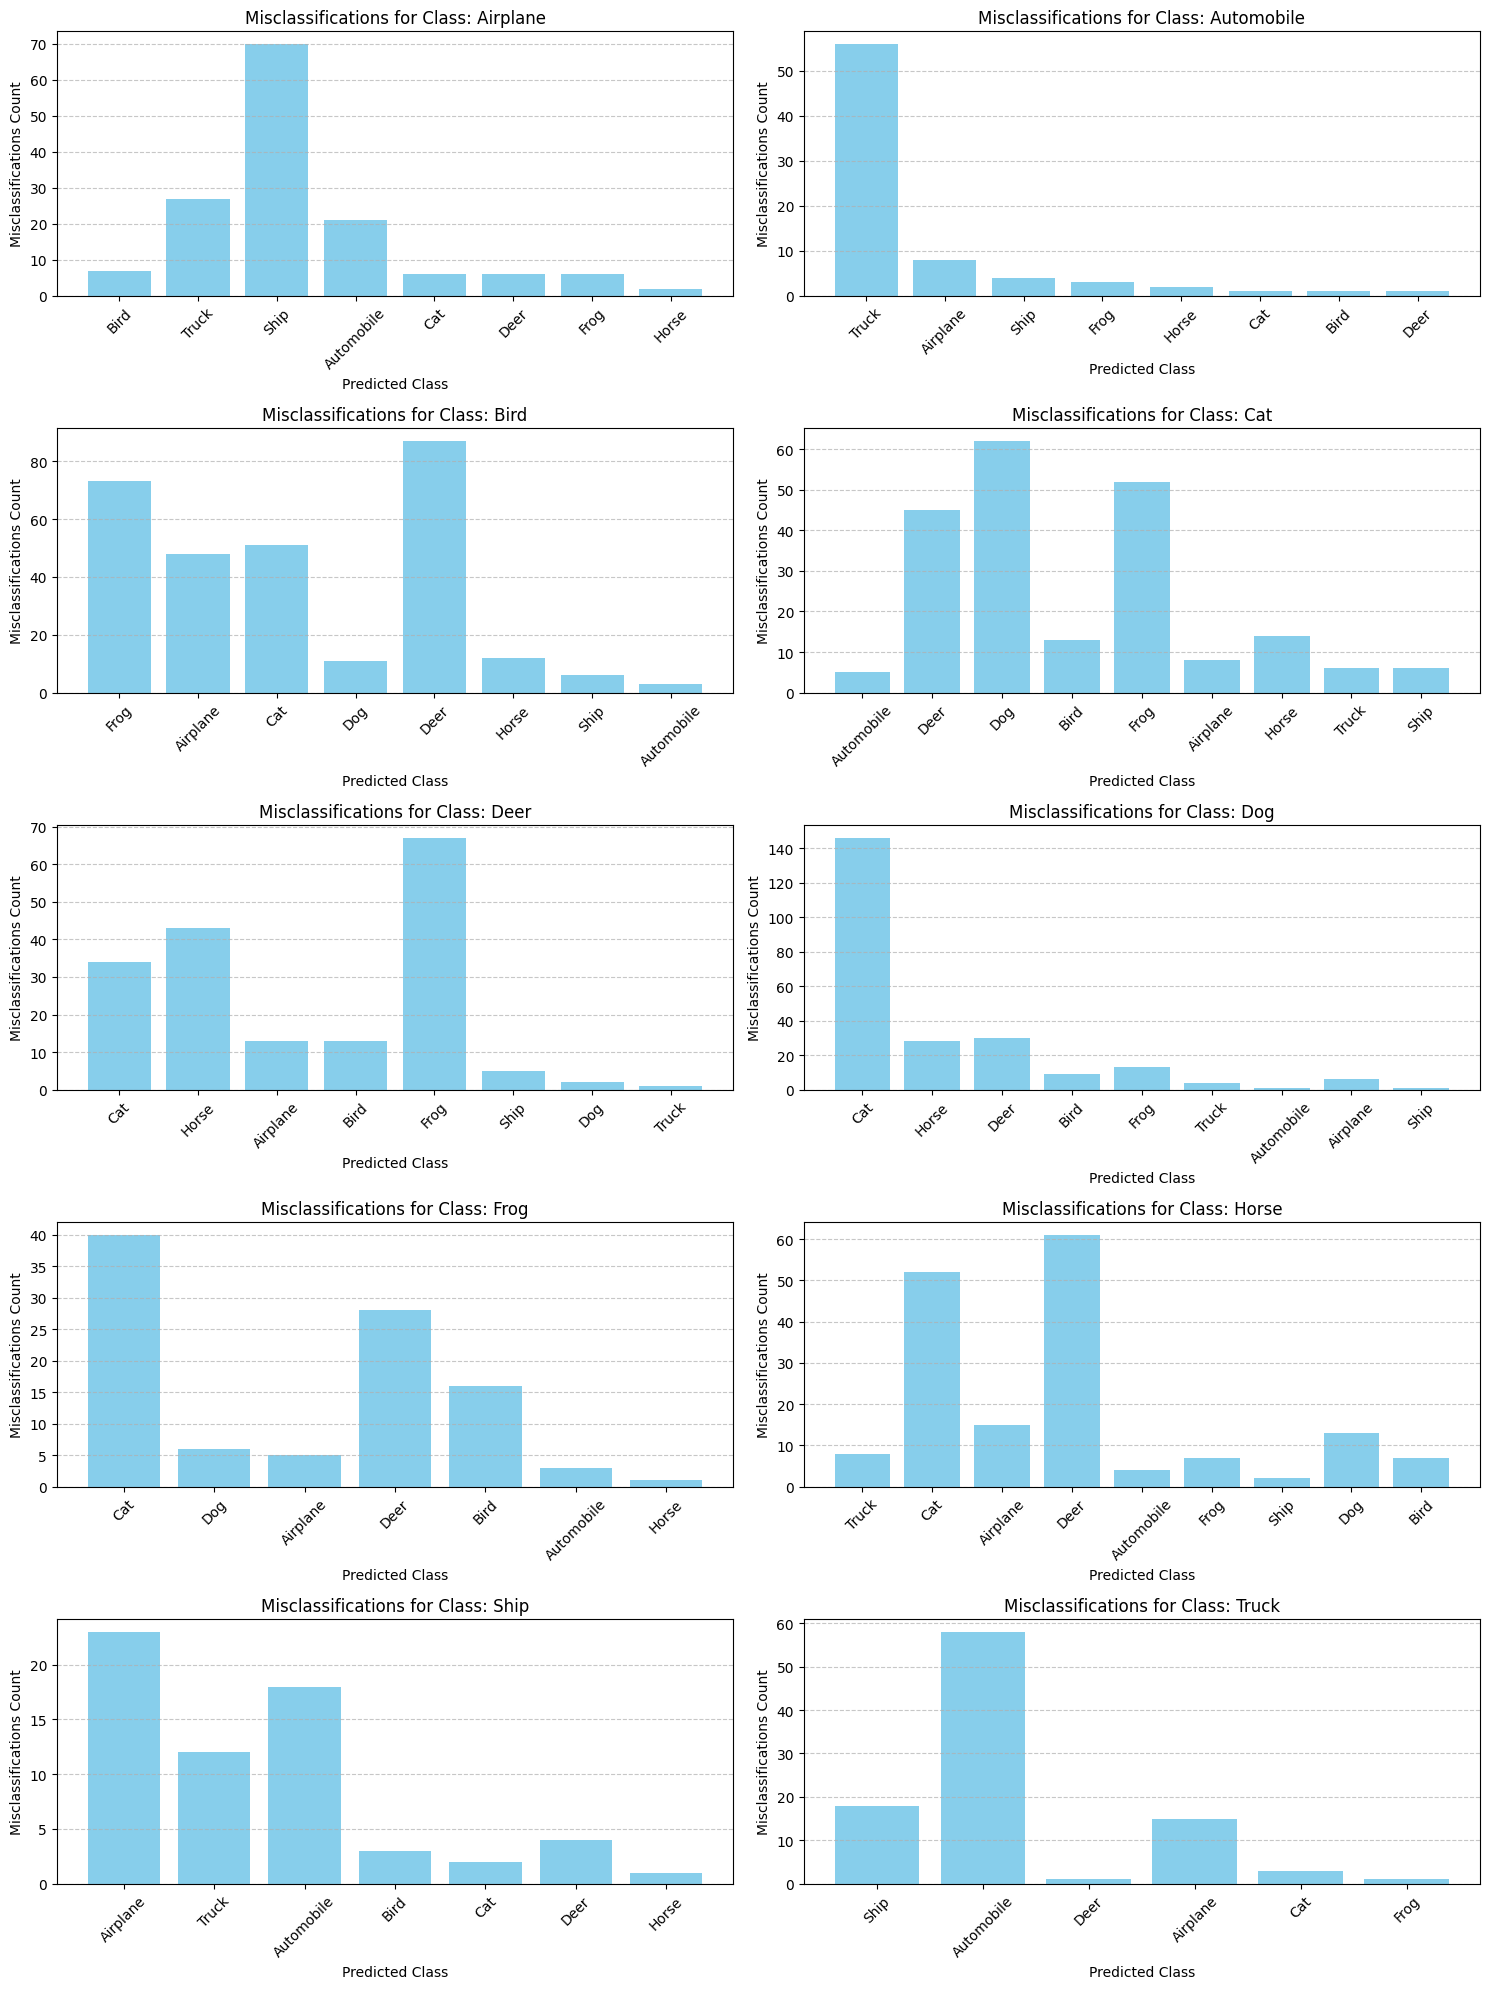

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Define class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Create a dictionary to store misclassifications count for each class
misclassifications_count_per_class = {class_name: defaultdict(int) for class_name in class_names}

# Iterate through the test set and count misclassifications per class
for true_label, predicted_label in zip(y_test, y_pred):
    if true_label != predicted_label:
        true_class_name = class_names[true_label]
        predicted_class_name = class_names[predicted_label]
        misclassifications_count_per_class[true_class_name][predicted_class_name] += 1

# Plot misclassifications count for each class using a single plot with multiple subplots
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i, class_name in enumerate(class_names):
    # Get misclassification counts for the current class
    misclassifications = misclassifications_count_per_class[class_name]
    
    # Convert misclassification counts dictionary to lists for plotting
    predicted_classes = list(misclassifications.keys())
    counts = list(misclassifications.values())
    
    # Plot the bar chart
    ax = axs[i // 2, i % 2]
    ax.bar(predicted_classes, counts, color='skyblue')
    ax.set_title(f'Misclassifications for Class: {class_name}')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Misclassifications Count')
    ax.set_xticks(range(len(predicted_classes)))  # Set the tick positions
    ax.set_xticklabels(predicted_classes, rotation=45)  # Set the tick labels
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


### Decision Tree

In [13]:
# Train Decision Tree classifier
decision_tree_model = DecisionTreeClassifier(criterion= "gini")
decision_tree_model.fit(X_train, y_train)

# Predict labels for test set
y_pred_decision_tree = decision_tree_model.predict(X_test)

accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree, average='weighted')
recall_decision_tree = recall_score(y_test, y_pred_decision_tree, average='weighted')
f1_decision_tree = f1_score(y_test, y_pred_decision_tree, average='weighted')

print("Accuracy of Decision Tree Classifier:", accuracy_decision_tree)
print("Precision of Decision Tree Classifier:", precision_decision_tree)
print("Recall of Decision Tree Classifier:", recall_decision_tree)
print("F1 Score of Decision Tree Classifier:", f1_decision_tree)

Accuracy of Decision Tree Classifier: 0.6464
Precision of Decision Tree Classifier: 0.6468763298116094
Recall of Decision Tree Classifier: 0.6464
F1 Score of Decision Tree Classifier: 0.6465918434471805


In [10]:
# Train Decision Tree classifier
decision_tree_model = DecisionTreeClassifier(criterion= "entropy")
decision_tree_model.fit(X_train, y_train)

# Predict labels for test set
y_pred_decision_tree = decision_tree_model.predict(X_test)

accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree, average='weighted')
recall_decision_tree = recall_score(y_test, y_pred_decision_tree, average='weighted')
f1_decision_tree = f1_score(y_test, y_pred_decision_tree, average='weighted')

print("Accuracy of Decision Tree Classifier:", accuracy_decision_tree)
print("Precision of Decision Tree Classifier:", precision_decision_tree)
print("Recall of Decision Tree Classifier:", recall_decision_tree)
print("F1 Score of Decision Tree Classifier:", f1_decision_tree)

Accuracy of Decision Tree Classifier: 0.6474
Precision of Decision Tree Classifier: 0.6474944155293165
Recall of Decision Tree Classifier: 0.6474
F1 Score of Decision Tree Classifier: 0.6473321876852658


In [11]:
# Train Decision Tree classifier
decision_tree_model = DecisionTreeClassifier(criterion= "entropy" , max_depth = 10 , min_samples_leaf = 10 , min_samples_split = 15)
decision_tree_model.fit(X_train, y_train)

# Predict labels for test set
y_pred_decision_tree = decision_tree_model.predict(X_test)

accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree, average='weighted')
recall_decision_tree = recall_score(y_test, y_pred_decision_tree, average='weighted')
f1_decision_tree = f1_score(y_test, y_pred_decision_tree, average='weighted')

print("Accuracy of Decision Tree Classifier:", accuracy_decision_tree)
print("Precision of Decision Tree Classifier:", precision_decision_tree)
print("Recall of Decision Tree Classifier:", recall_decision_tree)
print("F1 Score of Decision Tree Classifier:", f1_decision_tree)

Accuracy of Decision Tree Classifier: 0.6729
Precision of Decision Tree Classifier: 0.6766945028051398
Recall of Decision Tree Classifier: 0.6729
F1 Score of Decision Tree Classifier: 0.6733743228924504


In [21]:
from sklearn.model_selection import GridSearchCV

dt_hp = DecisionTreeClassifier()
params = {'max_depth':[8,10,12],
          'min_samples_leaf':[10, 12, 14],
          'min_samples_split':[10,13,15 , 17],
          'criterion':['entropy']}
GS = GridSearchCV(estimator=dt_hp,param_grid=params,cv=3,n_jobs=-1, verbose=True, scoring='accuracy')
GS.fit(X_train, y_train)
print('Best Parameters:',GS.best_params_,end='\n\n')
print('Best Score:',GS.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 12, 'min_samples_split': 15}

Best Score: 0.6634599229292265


Misclassifications count per class:
Class 8: 232 misclassifications
Class 6: 291 misclassifications
Class 0: 296 misclassifications
Class 5: 368 misclassifications
Class 7: 380 misclassifications
Class 4: 390 misclassifications
Class 2: 457 misclassifications
Class 1: 239 misclassifications
Class 9: 205 misclassifications
Class 3: 413 misclassifications


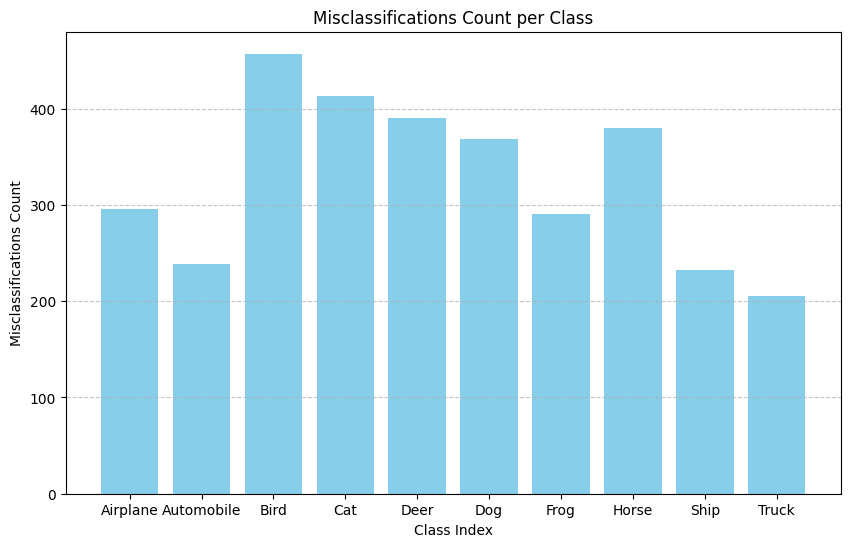

In [13]:
from collections import defaultdict
import matplotlib.pyplot as plt
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Make predictions on the test set
y_pred = decision_tree_model.predict(X_test)

# Create a dictionary to store misclassifications count for each class
misclassifications_count = defaultdict(int)

# Iterate through the test set and count misclassifications
for true_label, predicted_label in zip(y_test, y_pred):
    if true_label != predicted_label:
        misclassifications_count[true_label] += 1

# Print misclassifications count for each class
print("Misclassifications count per class:")
for class_index, count in misclassifications_count.items():
    print(f"Class {class_index}: {count} misclassifications")

# Visualize misclassifications 
# Convert misclassifications count dictionary to lists for plotting
classes = list(misclassifications_count.keys())
misclassifications = [misclassifications_count[i] for i in range(len(class_names))]

# Plot misclassifications count for each class using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, misclassifications, color='skyblue')
plt.title('Misclassifications Count per Class')
plt.xlabel('Class Index')
plt.ylabel('Misclassifications Count')
plt.xticks(classes)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


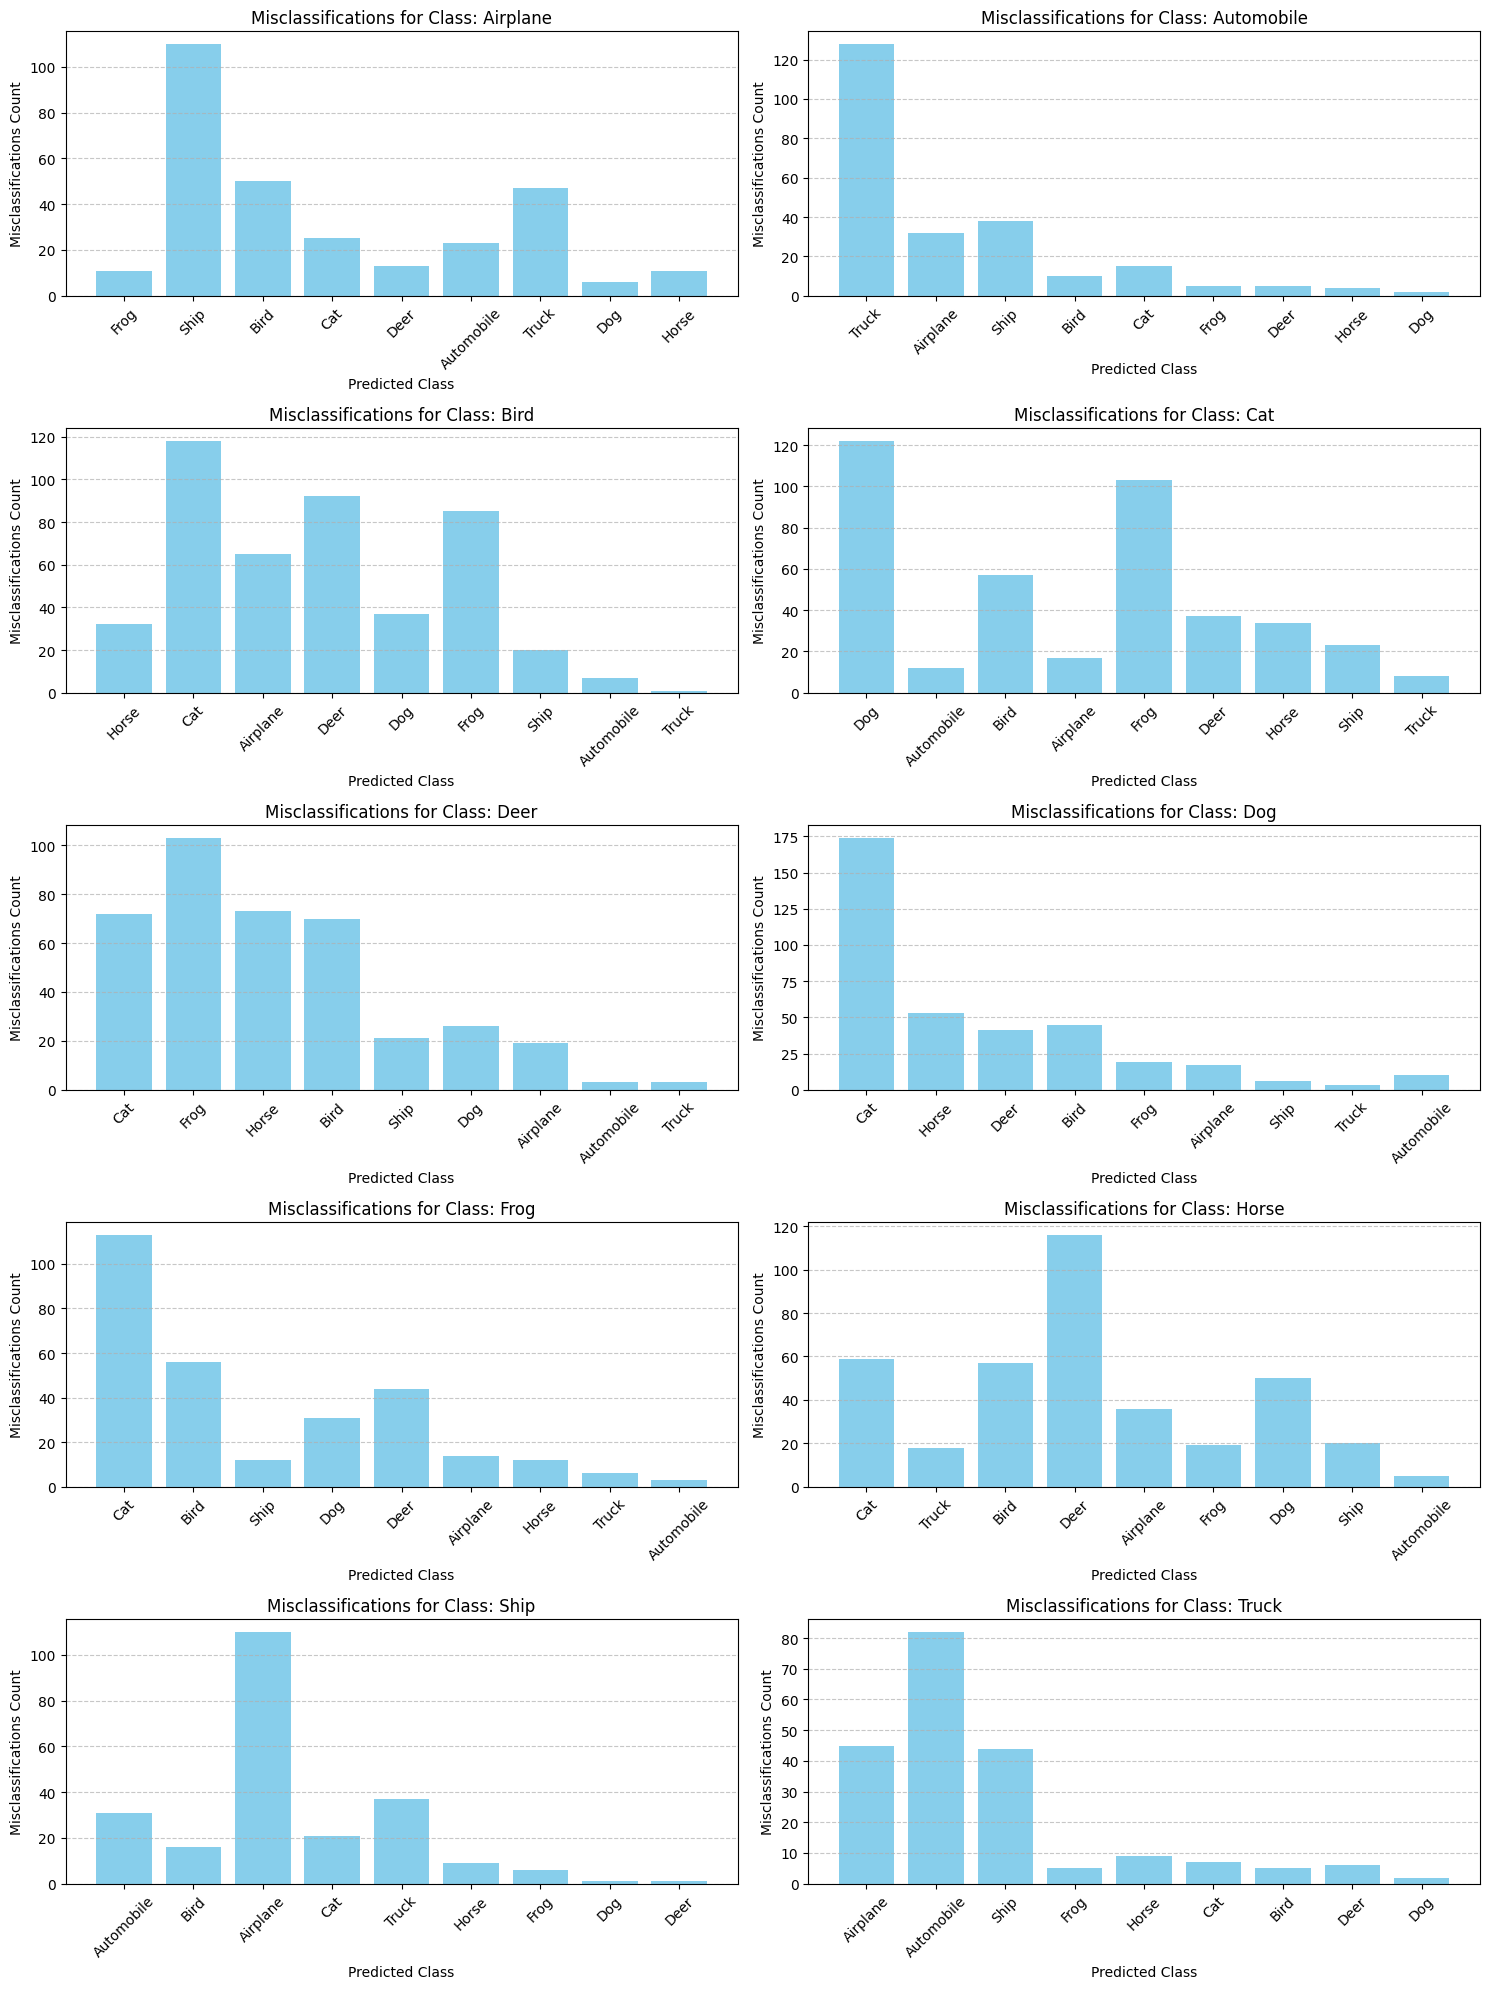

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Define class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Create a dictionary to store misclassifications count for each class
misclassifications_count_per_class = {class_name: defaultdict(int) for class_name in class_names}

# Iterate through the test set and count misclassifications per class
for true_label, predicted_label in zip(y_test, y_pred):
    if true_label != predicted_label:
        true_class_name = class_names[true_label]
        predicted_class_name = class_names[predicted_label]
        misclassifications_count_per_class[true_class_name][predicted_class_name] += 1

# Plot misclassifications count for each class using a single plot with multiple subplots
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i, class_name in enumerate(class_names):
    # Get misclassification counts for the current class
    misclassifications = misclassifications_count_per_class[class_name]
    
    # Convert misclassification counts dictionary to lists for plotting
    predicted_classes = list(misclassifications.keys())
    counts = list(misclassifications.values())
    
    # Plot the bar chart
    ax = axs[i // 2, i % 2]
    ax.bar(predicted_classes, counts, color='skyblue')
    ax.set_title(f'Misclassifications for Class: {class_name}')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Misclassifications Count')
    ax.set_xticks(range(len(predicted_classes)))  # Set the tick positions
    ax.set_xticklabels(predicted_classes, rotation=45)  # Set the tick labels
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Random Forest

In [15]:
# Train Random Forest classifier
random_forest_model = RandomForestClassifier(max_depth = 10 , min_samples_leaf = 10 , min_samples_split = 15)
random_forest_model.fit(X_train, y_train)

y_pred_random_forest = random_forest_model.predict(X_test)


accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
precision_random_forest = precision_score(y_test, y_pred_random_forest, average='weighted')
recall_random_forest = recall_score(y_test, y_pred_random_forest, average='weighted')
f1_random_forest = f1_score(y_test, y_pred_random_forest, average='weighted')

print("Accuracy of Random Forest Classifier:", accuracy_random_forest)
print("Precision of Random Forest Classifier:", precision_random_forest)
print("Recall of Random Forest Classifier:", recall_random_forest)
print("F1 Score of Random Forest Classifier:", f1_random_forest)

Accuracy of Random Forest Classifier: 0.811
Precision of Random Forest Classifier: 0.8152980412646682
Recall of Random Forest Classifier: 0.811
F1 Score of Random Forest Classifier: 0.8111764787407822


In [25]:
from sklearn.model_selection import GridSearchCV

rf_hp = RandomForestClassifier()
params = {'max_depth':[8,10 , 12],
          'min_samples_leaf':[8 ,10 ,12],
          'min_samples_split':[13,15,17],
          'n_estimators': [250,300]
          }
GS = GridSearchCV(estimator=rf_hp,param_grid=params,cv=2,n_jobs=-1, verbose=True, scoring='accuracy')
GS.fit(X_train, y_train)
print('Best Parameters:',GS.best_params_,end='\n\n')
print('Best Score:',GS.best_score_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


c:\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 250}

Best Score: 0.82062


Misclassifications count per class:
Class 8: 80 misclassifications
Class 4: 257 misclassifications
Class 1: 115 misclassifications
Class 9: 111 misclassifications
Class 7: 240 misclassifications
Class 6: 133 misclassifications
Class 3: 248 misclassifications
Class 5: 229 misclassifications
Class 2: 314 misclassifications
Class 0: 163 misclassifications


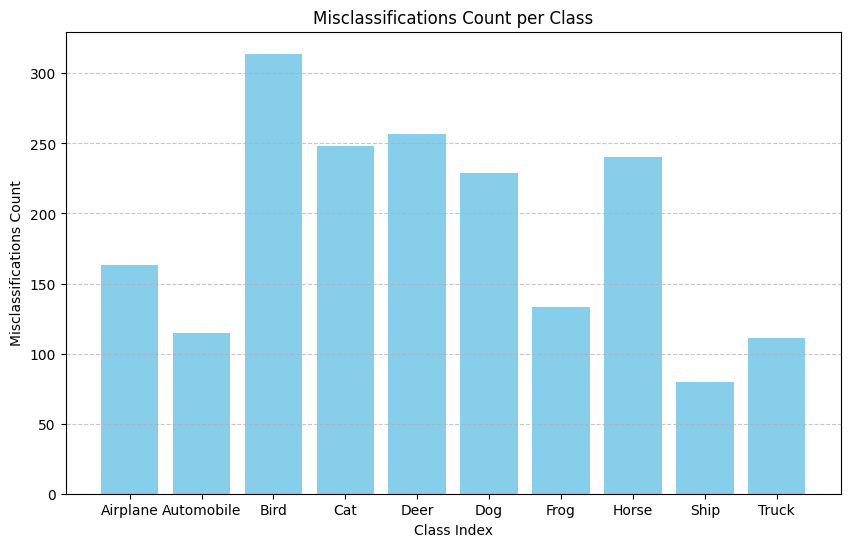

In [16]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = random_forest_model.predict(X_test)

# Create a dictionary to store misclassifications count for each class
misclassifications_count = defaultdict(int)

# Iterate through the test set and count misclassifications
for true_label, predicted_label in zip(y_test, y_pred):
    if true_label != predicted_label:
        misclassifications_count[true_label] += 1

# Print misclassifications count for each class
print("Misclassifications count per class:")
for class_index, count in misclassifications_count.items():
    print(f"Class {class_index}: {count} misclassifications")

# Visualize misclassifications 
# Convert misclassifications count dictionary to lists for plotting
classes = list(misclassifications_count.keys())
misclassifications = [misclassifications_count[i] for i in range(len(class_names))]

# Plot misclassifications count for each class using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, misclassifications, color='skyblue')
plt.title('Misclassifications Count per Class')
plt.xlabel('Class Index')
plt.ylabel('Misclassifications Count')
plt.xticks(classes)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


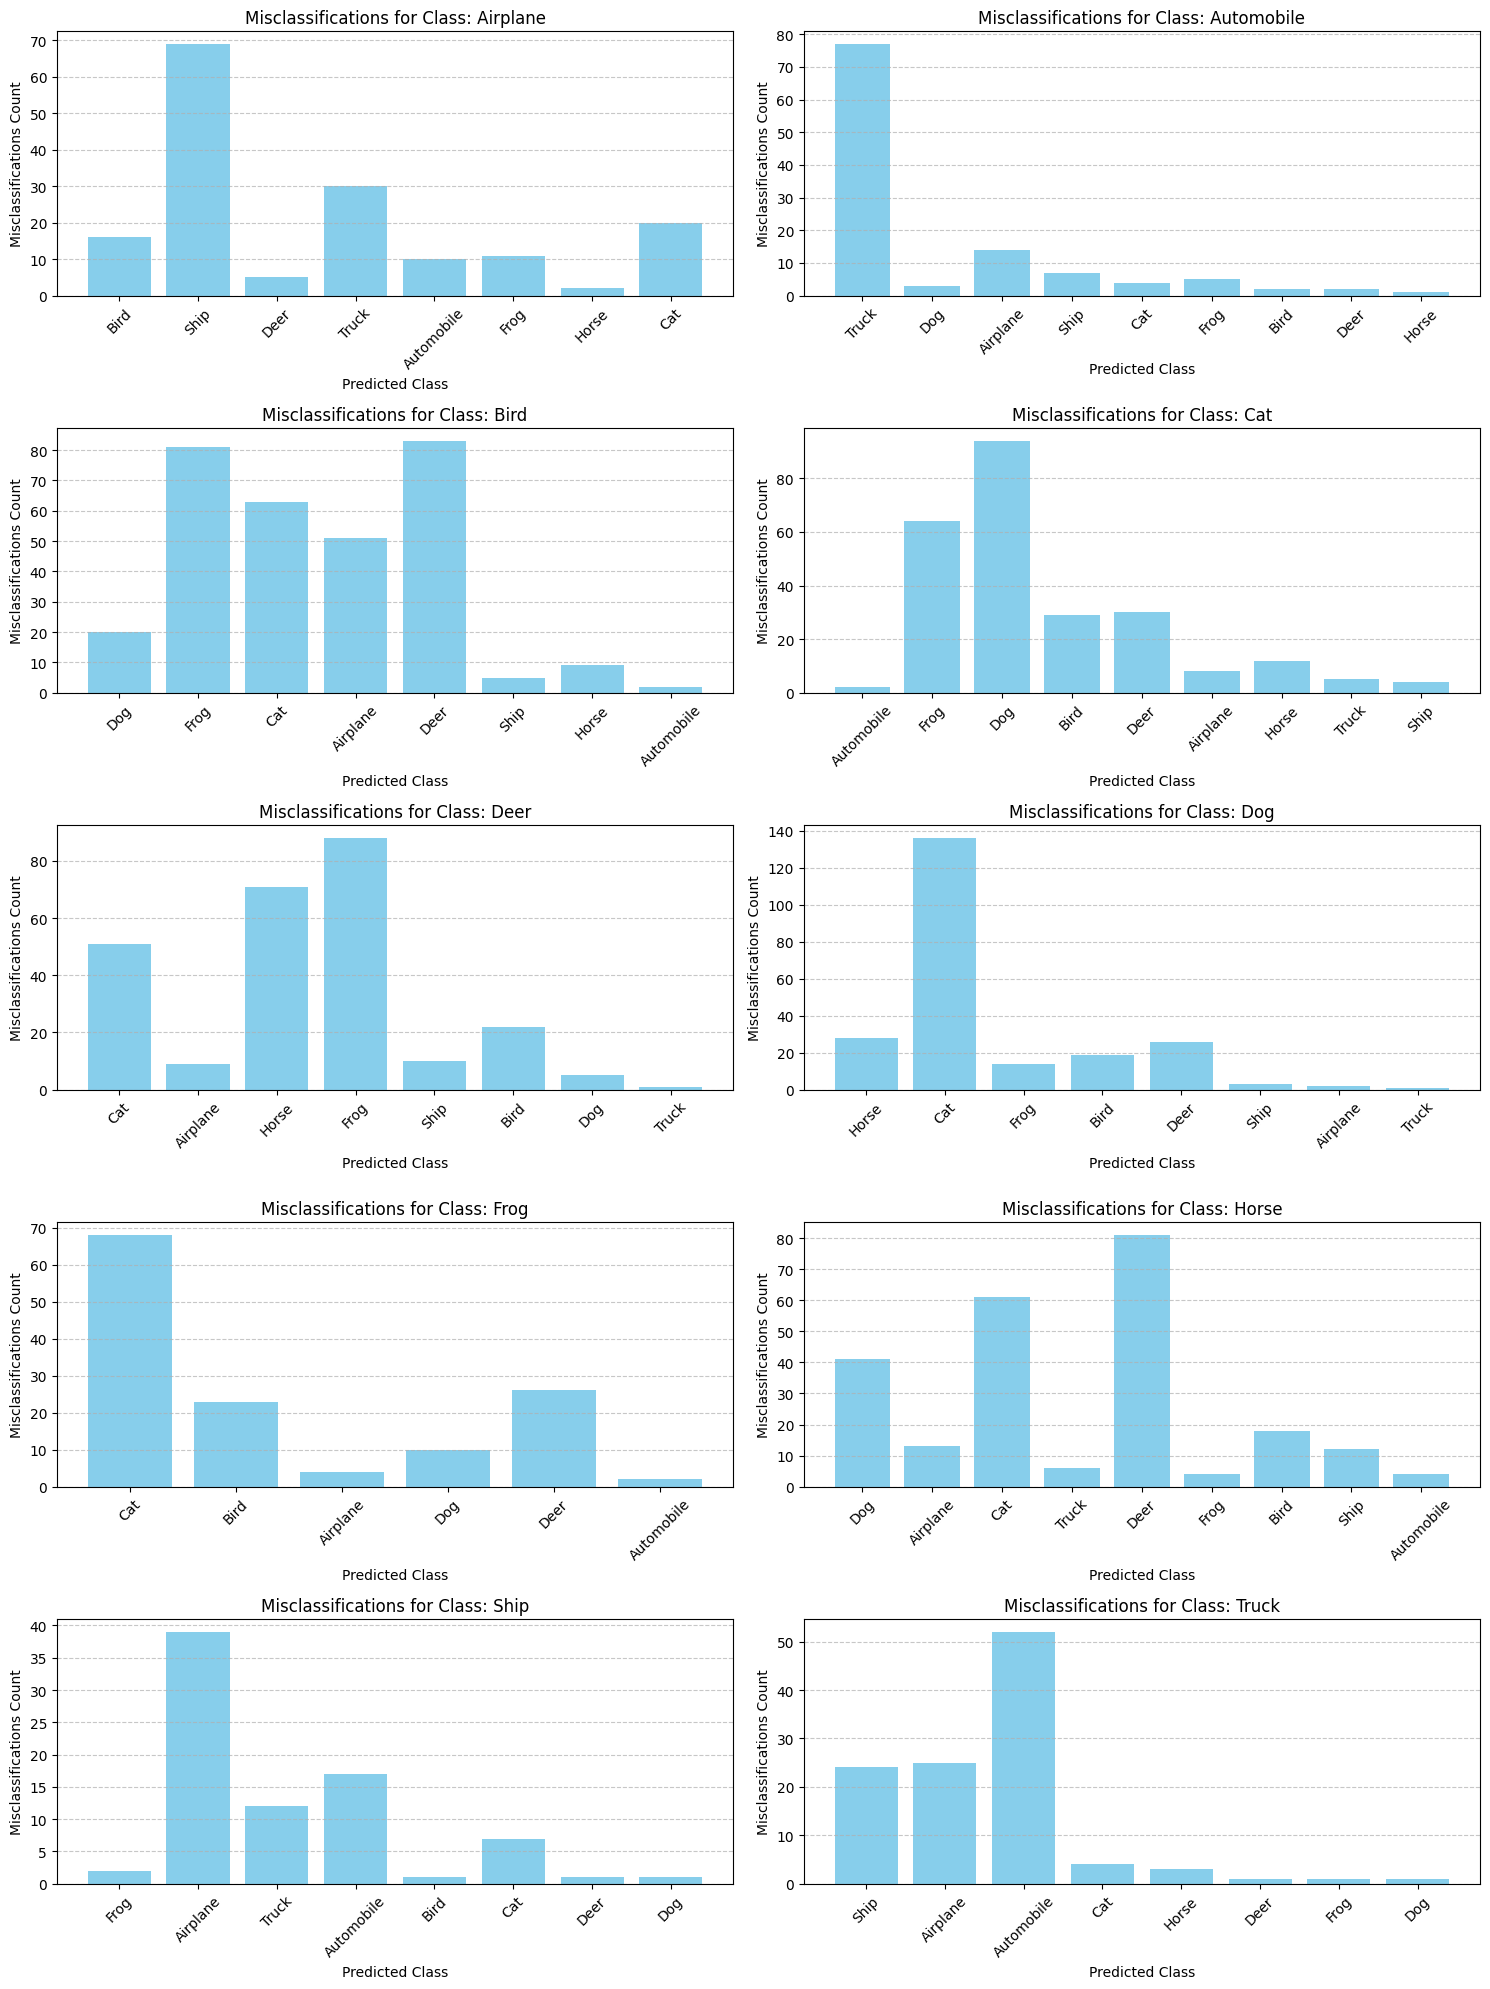

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Define class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Create a dictionary to store misclassifications count for each class
misclassifications_count_per_class = {class_name: defaultdict(int) for class_name in class_names}

# Iterate through the test set and count misclassifications per class
for true_label, predicted_label in zip(y_test, y_pred):
    if true_label != predicted_label:
        true_class_name = class_names[true_label]
        predicted_class_name = class_names[predicted_label]
        misclassifications_count_per_class[true_class_name][predicted_class_name] += 1

# Plot misclassifications count for each class using a single plot with multiple subplots
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i, class_name in enumerate(class_names):
    # Get misclassification counts for the current class
    misclassifications = misclassifications_count_per_class[class_name]
    
    # Convert misclassification counts dictionary to lists for plotting
    predicted_classes = list(misclassifications.keys())
    counts = list(misclassifications.values())
    
    # Plot the bar chart
    ax = axs[i // 2, i % 2]
    ax.bar(predicted_classes, counts, color='skyblue')
    ax.set_title(f'Misclassifications for Class: {class_name}')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Misclassifications Count')
    ax.set_xticks(range(len(predicted_classes)))  # Set the tick positions
    ax.set_xticklabels(predicted_classes, rotation=45)  # Set the tick labels
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Naive Bayes

In [9]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train, y_train)

y_pred_naive_bayes = naive_bayes_model.predict(X_test)

accuracy_naive_bayes = accuracy_score(y_test, y_pred_naive_bayes)
precision_naive_bayes = precision_score(y_test, y_pred_naive_bayes, average='weighted')
recall_naive_bayes = recall_score(y_test, y_pred_naive_bayes, average='weighted')
f1_naive_bayes = f1_score(y_test, y_pred_naive_bayes, average='weighted')

print("Accuracy of Naive Bayes Classifier:", accuracy_naive_bayes)
print("Precision of Naive Bayes Classifier:", precision_naive_bayes)
print("Recall of Naive Bayes Classifier:", recall_naive_bayes)
print("F1 Score of Naive Bayes Classifier:", f1_naive_bayes)


Accuracy of Naive Bayes Classifier: 0.7916
Precision of Naive Bayes Classifier: 0.7945136947402487
Recall of Naive Bayes Classifier: 0.7916
F1 Score of Naive Bayes Classifier: 0.7915931712670695


In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# Define the parameter grid
param_grid = {
    'alpha': [1.0, 2.0, 2.5 , 3.0 , 5.0]  # You can adjust the range of alpha values
}

# Initialize Multinomial Naive Bayes classifier
mnb_classifier = MultinomialNB()

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(mnb_classifier, param_grid, cv=3, n_jobs=-1)

# Fit the Grid Search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(grid_search.best_params_)

# Get the best model
best_mnb_classifier = grid_search.best_estimator_

# Make predictions using the best model
y_pred = best_mnb_classifier.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



Best hyperparameters found:
{'alpha': 2.0}
Accuracy: 0.7915


In [11]:

# Train Naive Bayes classifier
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train, y_train)

y_pred_naive_bayes = naive_bayes_model.predict(X_test)

accuracy_naive_bayes = accuracy_score(y_test, y_pred_naive_bayes)
precision_naive_bayes = precision_score(y_test, y_pred_naive_bayes, average='weighted')
recall_naive_bayes = recall_score(y_test, y_pred_naive_bayes, average='weighted')
f1_naive_bayes = f1_score(y_test, y_pred_naive_bayes, average='weighted')

print("Accuracy of Naive Bayes Classifier:", accuracy_naive_bayes)
print("Precision of Naive Bayes Classifier:", precision_naive_bayes)
print("Recall of Naive Bayes Classifier:", recall_naive_bayes)
print("F1 Score of Naive Bayes Classifier:", f1_naive_bayes)

Accuracy of Naive Bayes Classifier: 0.7948
Precision of Naive Bayes Classifier: 0.797058885568306
Recall of Naive Bayes Classifier: 0.7948
F1 Score of Naive Bayes Classifier: 0.794656614631248


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

# Define the parameter grid
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # You can adjust the range of var_smoothing values
}

# Initialize Gaussian Naive Bayes classifier
gnb_classifier = GaussianNB()

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(gnb_classifier, param_grid, cv=3, n_jobs=-1)

# Fit the Grid Search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(grid_search.best_params_)

# Get the best model
best_gnb_classifier = grid_search.best_estimator_

# Make predictions using the best model
y_pred = best_gnb_classifier.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Best hyperparameters found:
{'var_smoothing': 1e-09}
Accuracy: 0.7948


Misclassifications count per class:
Class 6: 150 misclassifications
Class 8: 96 misclassifications
Class 4: 262 misclassifications
Class 2: 327 misclassifications
Class 3: 294 misclassifications
Class 7: 238 misclassifications
Class 1: 135 misclassifications
Class 5: 228 misclassifications
Class 0: 207 misclassifications
Class 9: 115 misclassifications


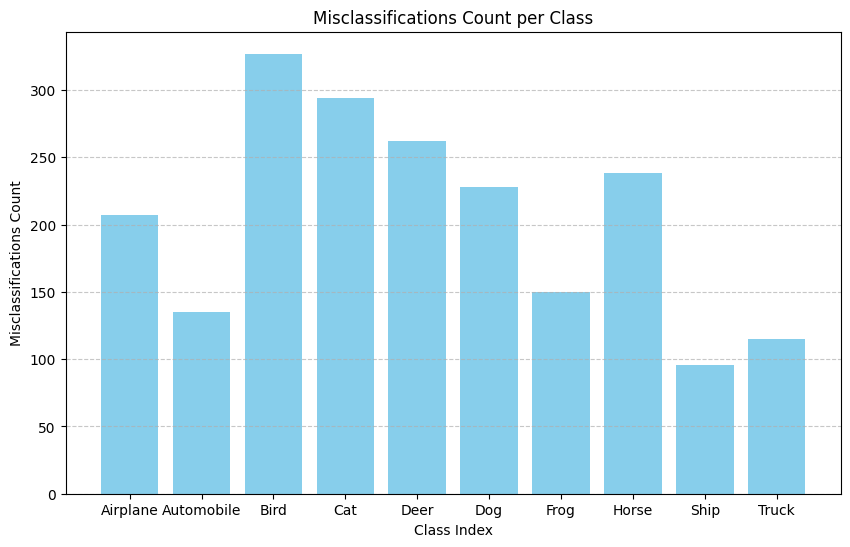

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = naive_bayes_model.predict(X_test)

# Create a dictionary to store misclassifications count for each class
misclassifications_count = defaultdict(int)

# Iterate through the test set and count misclassifications
for true_label, predicted_label in zip(y_test, y_pred):
    if true_label != predicted_label:
        misclassifications_count[true_label] += 1

# Print misclassifications count for each class
print("Misclassifications count per class:")
for class_index, count in misclassifications_count.items():
    print(f"Class {class_index}: {count} misclassifications")

# Visualize misclassifications 
# Convert misclassifications count dictionary to lists for plotting
classes = list(misclassifications_count.keys())
misclassifications = [misclassifications_count[i] for i in range(len(class_names))]

# Plot misclassifications count for each class using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, misclassifications, color='skyblue')
plt.title('Misclassifications Count per Class')
plt.xlabel('Class Index')
plt.ylabel('Misclassifications Count')
plt.xticks(classes)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


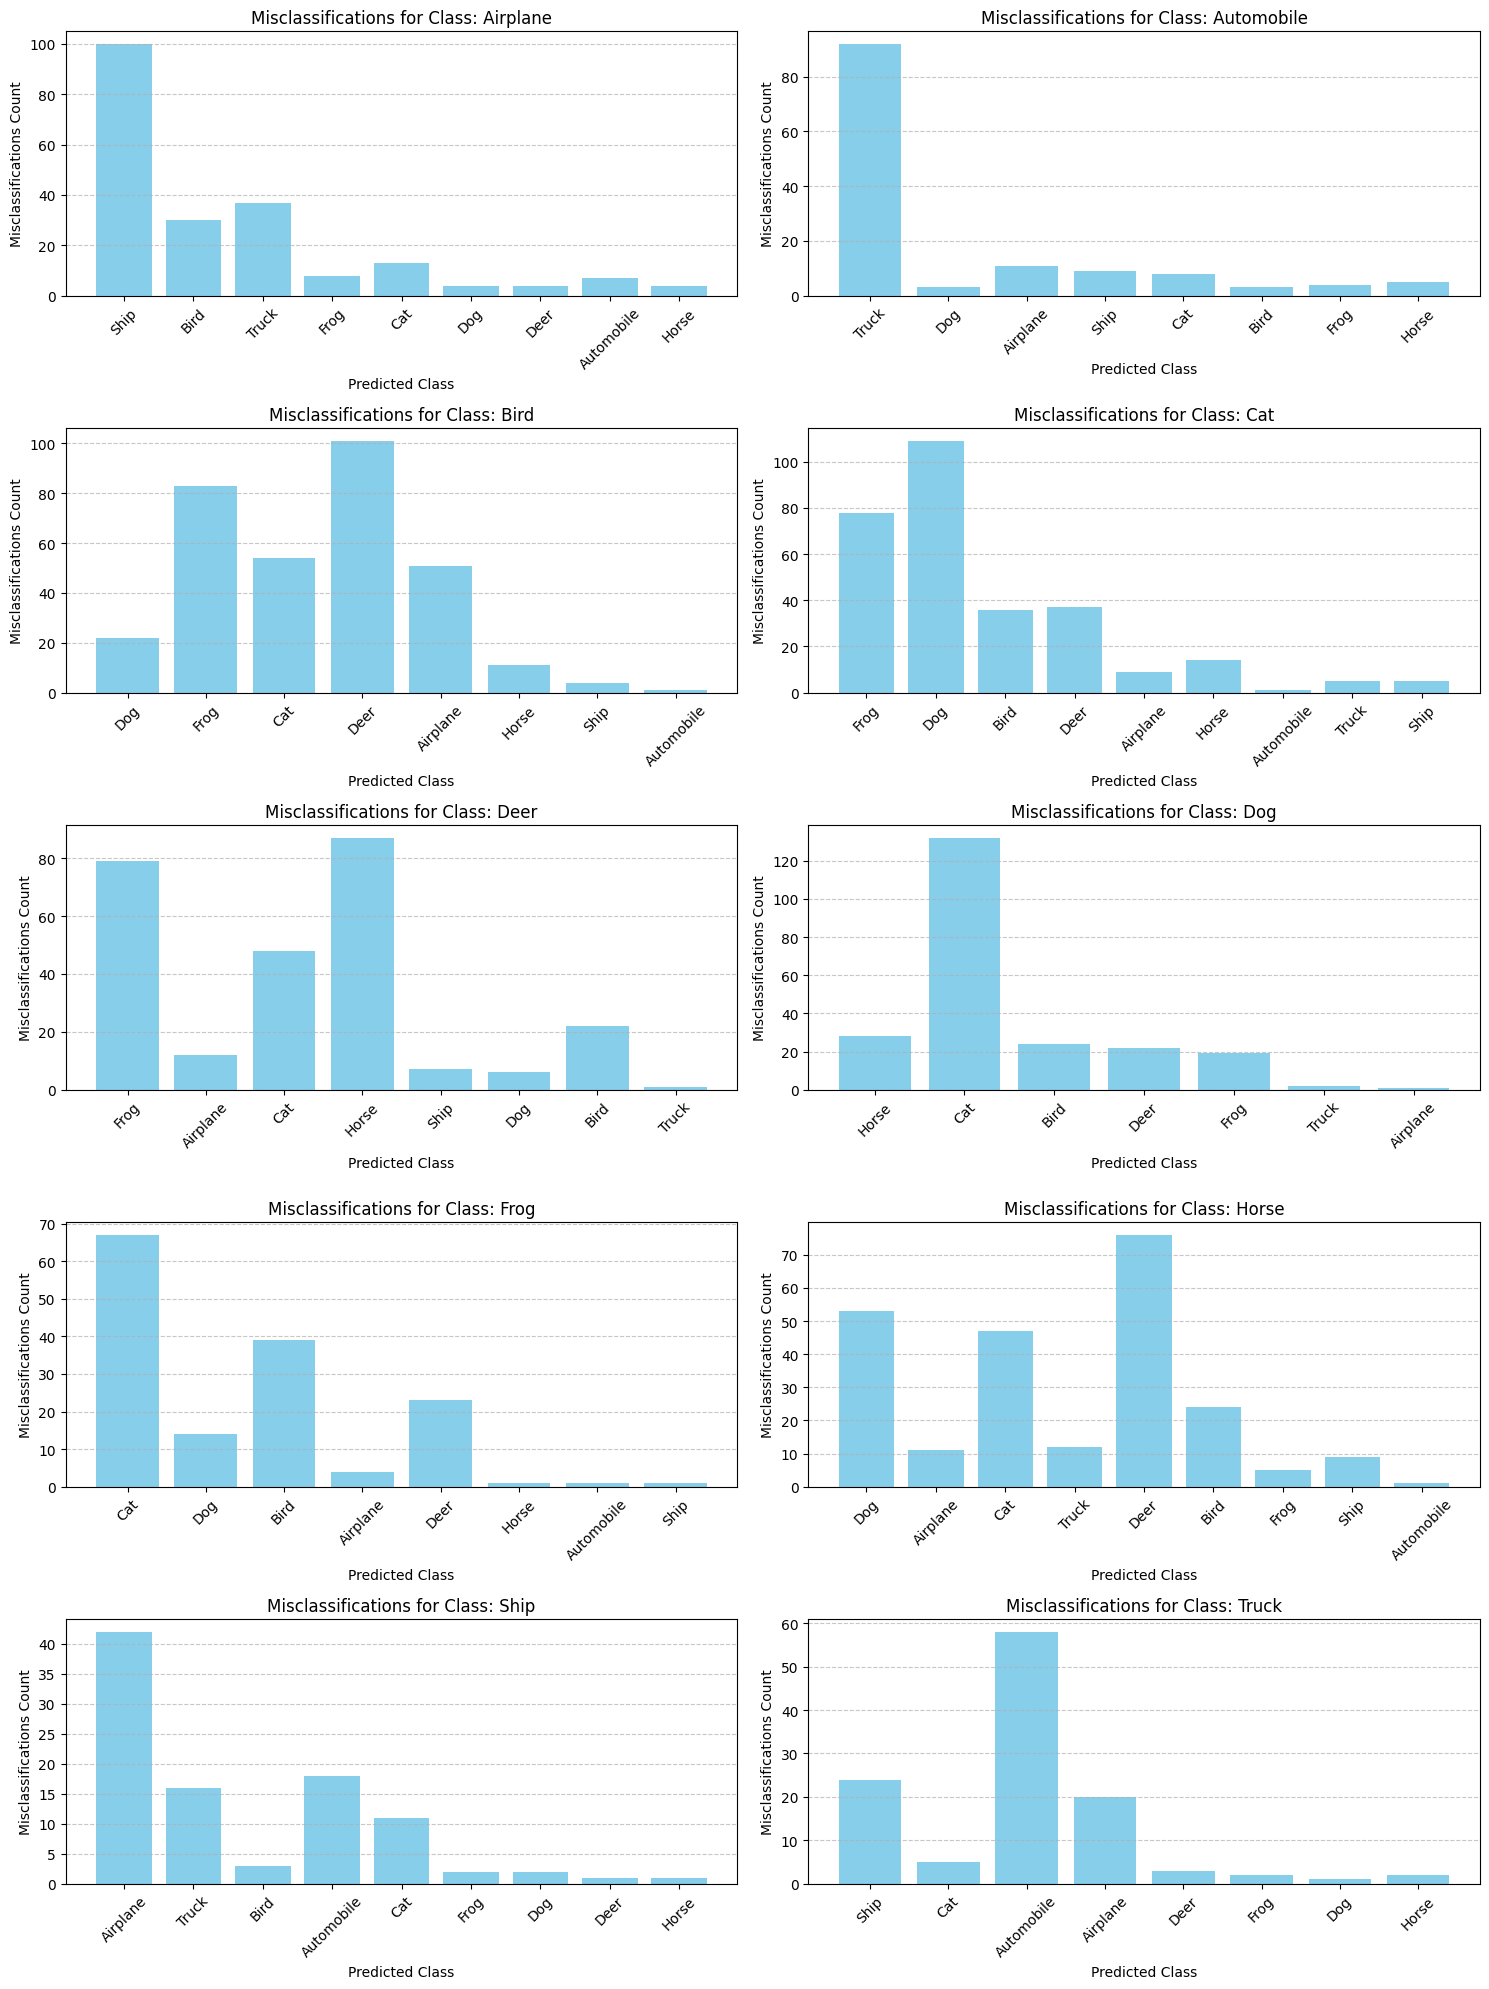

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Define class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Create a dictionary to store misclassifications count for each class
misclassifications_count_per_class = {class_name: defaultdict(int) for class_name in class_names}

# Iterate through the test set and count misclassifications per class
for true_label, predicted_label in zip(y_test, y_pred):
    if true_label != predicted_label:
        true_class_name = class_names[true_label]
        predicted_class_name = class_names[predicted_label]
        misclassifications_count_per_class[true_class_name][predicted_class_name] += 1

# Plot misclassifications count for each class using a single plot with multiple subplots
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i, class_name in enumerate(class_names):
    # Get misclassification counts for the current class
    misclassifications = misclassifications_count_per_class[class_name]
    
    # Convert misclassification counts dictionary to lists for plotting
    predicted_classes = list(misclassifications.keys())
    counts = list(misclassifications.values())
    
    # Plot the bar chart
    ax = axs[i // 2, i % 2]
    ax.bar(predicted_classes, counts, color='skyblue')
    ax.set_title(f'Misclassifications for Class: {class_name}')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Misclassifications Count')
    ax.set_xticks(range(len(predicted_classes)))  # Set the tick positions
    ax.set_xticklabels(predicted_classes, rotation=45)  # Set the tick labels
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### SVM


In [17]:
# Train the SVM model
svm_classifier = SVC(kernel='poly', gamma='scale', C=1.0)  # You can adjust kernel, gamma, and C parameters
svm_classifier.fit(X_train, y_train)

# Make predictions
y_pred = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8984


In [13]:
# Train the SVM model
svm_classifier = SVC(kernel='rbf', gamma='scale', C=1.0)  # You can adjust kernel, gamma, and C parameters
svm_classifier.fit(X_train, y_train)

# Make predictions
y_pred = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8919


In [16]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.8, 1, 2],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf']
}

# Initialize SVM classifier
svm_classifier = SVC()

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(svm_classifier, param_grid, cv=3)

# Fit the Grid Search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(grid_search.best_params_)
print("Accuracy:", accuracy)
print('Best Score:',GS.best_score_)



KeyboardInterrupt: 

Misclassifications count per class:
Class 6: 70 misclassifications
Class 1: 64 misclassifications
Class 7: 117 misclassifications
Class 4: 127 misclassifications
Class 3: 198 misclassifications
Class 2: 156 misclassifications
Class 0: 75 misclassifications
Class 9: 77 misclassifications
Class 8: 43 misclassifications
Class 5: 154 misclassifications


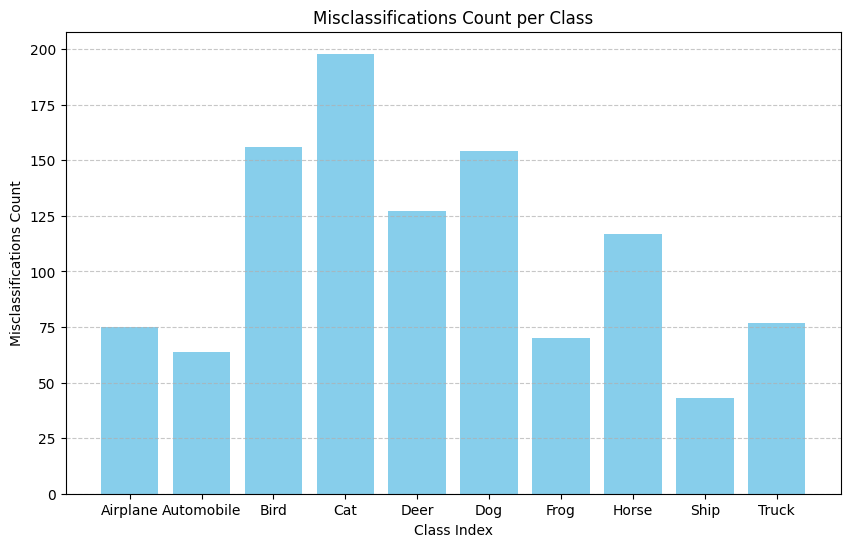

In [15]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Create a dictionary to store misclassifications count for each class
misclassifications_count = defaultdict(int)
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Iterate through the test set and count misclassifications
for true_label, predicted_label in zip(y_test, y_pred):
    if true_label != predicted_label:
        misclassifications_count[true_label] += 1

# Print misclassifications count for each class
print("Misclassifications count per class:")
for class_index, count in misclassifications_count.items():
    print(f"Class {class_index}: {count} misclassifications")

# Visualize misclassifications 
# Convert misclassifications count dictionary to lists for plotting
classes = list(misclassifications_count.keys())
misclassifications = [misclassifications_count[i] for i in range(len(class_names))]

# Plot misclassifications count for each class using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, misclassifications, color='skyblue')
plt.title('Misclassifications Count per Class')
plt.xlabel('Class Index')
plt.ylabel('Misclassifications Count')
plt.xticks(classes)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Create a dictionary to store misclassifications count for each class
misclassifications_count_per_class = {class_name: defaultdict(int) for class_name in class_names}

# Iterate through the test set and count misclassifications per class
for true_label, predicted_label in zip(y_test, y_pred):
    if true_label != predicted_label:
        true_class_name = class_names[true_label]
        predicted_class_name = class_names[predicted_label]
        misclassifications_count_per_class[true_class_name][predicted_class_name] += 1

# Plot misclassifications count for each class using a single plot with multiple subplots
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i, class_name in enumerate(class_names):
    # Get misclassification counts for the current class
    misclassifications = misclassifications_count_per_class[class_name]
    
    # Convert misclassification counts dictionary to lists for plotting
    predicted_classes = list(misclassifications.keys())
    counts = list(misclassifications.values())
    
    # Plot the bar chart
    ax = axs[i // 2, i % 2]
    ax.bar(predicted_classes, counts, color='skyblue')
    ax.set_title(f'Misclassifications for Class: {class_name}')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Misclassifications Count')
    ax.set_xticks(range(len(predicted_classes)))  # Set the tick positions
    ax.set_xticklabels(predicted_classes, rotation=45)  # Set the tick labels
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## HoG Features

In [ ]:
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
import matplotlib.pyplot as plt

In [ ]:

def compute_hog(img):
    # Resize the image while preserving aspect ratio
    resized_img = resize(img, (32, 32))
    # Compute HOG features
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    return fd

# Concatenate the X_test and X_train arrays
all_images = np.concatenate((X_train, X_test), axis=0)

# Compute HOG features for all images in the concatenated dataset
all_hog_features = []
for img in all_images:
    hog_features = compute_hog(img)
    all_hog_features.append(hog_features)

# Convert the list of HOG features to a numpy array
all_hog_features = np.array(all_hog_features)

# Separate the HOG features for testing and training images
num_train_images = len(X_train)
all_hog_features_train = all_hog_features[:num_train_images]
all_hog_features_test = all_hog_features[num_train_images:]

# Save the numpy arrays containing all HOG features to a file
np.savez('cifar10_hog_features.npz', X_train=all_hog_features_train, X_test=all_hog_features_test)



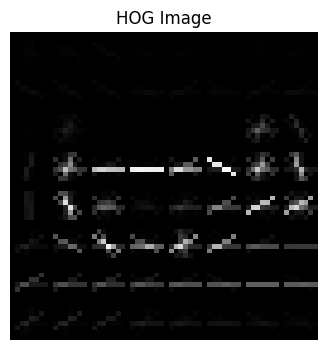

Text(0.5, 1.0, 'Original Image')

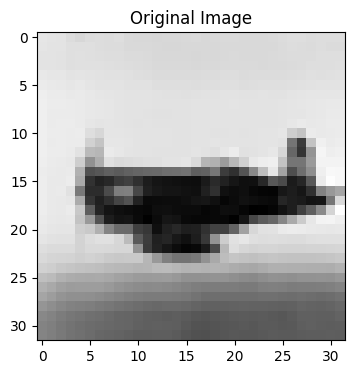

In [ ]:
def compute_hog(img):
    # Resize the image while preserving aspect ratio
    resized_img = resize(img, (64, 64))
    # Compute HOG features
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    return fd, hog_image

# Read an example image
Hog_feature, hog_image = compute_hog(X_train[115])

# Plot the HOG image
plt.figure(figsize=(8, 4))
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Image')
plt.axis('off')
plt.show()
plt.figure(figsize=(8, 4))
plt.imshow(X_train[115])
plt.title("Original Image")

Now applying the previously trained classical ML models, to check classification and comparing performance.


#### KNN


In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=8)
# Train the classifier
knn_classifier.fit(all_hog_features_train, y_train)

# Predict labels for test set
y_pred = knn_classifier.predict(all_hog_features_test)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy of KNN:", accuracy)
print("Precision of KNN:", precision)
print("Recall of KNN:", recall)
print("F1 Score of KNN:", f1)


c:\Python312\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy of KNN: 0.5235
Precision of KNN: 0.5721330502598757
Recall of KNN: 0.5235
F1 Score of KNN: 0.5180642025224663


#### Decision Tree

In [ ]:
# Train Decision Tree classifier
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(all_hog_features_train, y_train)

# Predict labels for test set
y_pred_decision_tree = decision_tree_model.predict(all_hog_features_test)

accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree, average='weighted')
recall_decision_tree = recall_score(y_test, y_pred_decision_tree, average='weighted')
f1_decision_tree = f1_score(y_test, y_pred_decision_tree, average='weighted')

print("Accuracy of Decision Tree Classifier:", accuracy_decision_tree)
print("Precision of Decision Tree Classifier:", precision_decision_tree)
print("Recall of Decision Tree Classifier:", recall_decision_tree)
print("F1 Score of Decision Tree Classifier:", f1_decision_tree)


Accuracy of Decision Tree Classifier: 0.279
Precision of Decision Tree Classifier: 0.28048685243083243
Recall of Decision Tree Classifier: 0.279
F1 Score of Decision Tree Classifier: 0.27966954478574946


#### Random Forest Classifier

In [ ]:
# Train Random Forest classifier
random_forest_model = RandomForestClassifier()
random_forest_model.fit(all_hog_features_train, y_train)

y_pred_random_forest = random_forest_model.predict(all_hog_features_test)


accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
precision_random_forest = precision_score(y_test, y_pred_random_forest, average='weighted')
recall_random_forest = recall_score(y_test, y_pred_random_forest, average='weighted')
f1_random_forest = f1_score(y_test, y_pred_random_forest, average='weighted')

print("Accuracy of Random Forest Classifier:", accuracy_random_forest)
print("Precision of Random Forest Classifier:", precision_random_forest)
print("Recall of Random Forest Classifier:", recall_random_forest)
print("F1 Score of Random Forest Classifier:", f1_random_forest)

c:\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy of Random Forest Classifier: 0.525
Precision of Random Forest Classifier: 0.521646415382805
Recall of Random Forest Classifier: 0.525
F1 Score of Random Forest Classifier: 0.5204869780514788


#### Naive Bayes Classifier

In [ ]:
# Train Naive Bayes classifier
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(all_hog_features_train, y_train)

y_pred_naive_bayes = naive_bayes_model.predict(all_hog_features_test)

accuracy_naive_bayes = accuracy_score(y_test, y_pred_naive_bayes)
precision_naive_bayes = precision_score(y_test, y_pred_naive_bayes, average='weighted')
recall_naive_bayes = recall_score(y_test, y_pred_naive_bayes, average='weighted')
f1_naive_bayes = f1_score(y_test, y_pred_naive_bayes, average='weighted')

print("Accuracy of Naive Bayes Classifier:", accuracy_naive_bayes)
print("Precision of Naive Bayes Classifier:", precision_naive_bayes)
print("Recall of Naive Bayes Classifier:", recall_naive_bayes)
print("F1 Score of Naive Bayes Classifier:", f1_naive_bayes)

c:\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of Naive Bayes Classifier: 0.4581
Precision of Naive Bayes Classifier: 0.4667085487081605
Recall of Naive Bayes Classifier: 0.4581
F1 Score of Naive Bayes Classifier: 0.4536907851130096
